# Prévisions météorologiques en Australie

# Prévision des précipitations sans étape de ré-échantillonage

## Récupération des librairies

In [1]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE

## Modèles de classification par apprentissage supervisé

### Préparation du jeu de données et paramètrage

In [3]:
# récuperation et aperçu du jeu de données après prétraitement des données, après l'étape de classification des villes 
# en fonction du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,5.183333,44.0,22.0,1007.7,6.50000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.630540,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,8.266667,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.630540,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.750000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [4]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [5]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement 
# à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [6]:
# distribution de la variable cible dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible dans l'ensemble d'entraînement:", 
      dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble d'entraînement: {0: 87624, 1: 25005}


In [7]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.777988
1    0.222012
Name: RainTomorrow, dtype: float64

In [8]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 21962, 1: 6196}


In [9]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [10]:
# paramètre à initialiser pour calculer les performances des algorithmes sans ré-échantillonage
param_ru = 'none'

In [11]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# paramètre à initialiser pour définir la règle d'évaluation des modèles
scoring = 'accuracy' # considéré dans le cadre de cette étude
# scoring = 'f1'

### Régression Logistique

In [13]:
# définition du modèle
clf_lr = LogisticRegression(class_weight={0:2, 1:1})

param_grid_lr = {'solver':['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 
                 'C':np.linspace(0.1,1,10)}

gcv_lr = GridSearchCV(clf_lr, param_grid_lr, scoring=scoring, cv=3)

In [14]:
start_time = time.time()

# entraînement du modèle
gcv_lr.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_lr.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr.best_params_, "\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'C': 1.0, 'solver': 'sag'} 

Accuracy Score: 0.836423041409191 

Train Data Score: 0.8313489421019453
Test Data Score: 0.836423041409191

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            21530   432
1             4174  2022

               precision    recall  f1-score   support

           0       0.84      0.98      0.90     21962
           1       0.82      0.33      0.47      6196

    accuracy                           0.84     28158
   macro avg       0.83      0.65      0.69     28158
weighted avg       0.83      0.84      0.81     28158

Running Time: 0:00:41.272726


- la méthode de régression logistique **ne fait pas l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.33.
- la spécificité (taux de vrais négatifs) vaut 0.98.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est très bon (0.90).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.47).

La classe '1' est caractérisée par une précision élevée, ce qui signifie que la classe est bien détectée, et un rappel très faible, ce qui signifie que la classe inclut beaucoup d'observations d'autres classes lorsqu'elle est détectée.

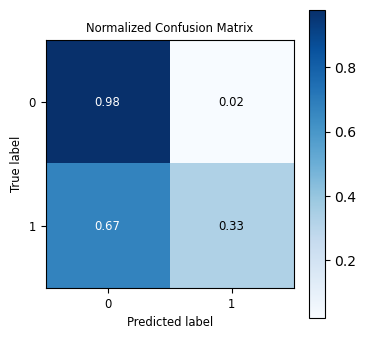

In [15]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), 
                                    title_fontsize='small', text_fontsize='small');

In [16]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_lr.cv_results_).loc[:,['params','rank_test_score','mean_test_score',
                                                         'mean_fit_time','mean_score_time']]
grid.set_index('rank_test_score').sort_values(by='rank_test_score')

,params,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,
1,"{'C': 1.0, 'solver': 'sag'}",0.831429,0.569900,0.005208
2,"{'C': 0.8, 'solver': 'saga'}",0.831420,0.324385,0.000000
2,"{'C': 0.7000000000000001, 'solver': 'saga'}",0.831420,0.301068,0.002503
2,"{'C': 0.9, 'solver': 'saga'}",0.831420,0.303090,0.000000
2,"{'C': 0.4, 'solver': 'sag'}",0.831420,0.513205,0.005208
6,"{'C': 1.0, 'solver': 'saga'}",0.831420,0.324285,0.000000
6,"{'C': 0.6, 'solver': 'newton-cg'}",0.831420,0.266752,0.000000
6,"{'C': 0.9, 'solver': 'lbfgs'}",0.831420,0.052203,0.013586
6,"{'C': 1.0, 'solver': 'lbfgs'}",0.831420,0.073296,0.005207


In [17]:
# méthode d'évaluation du score sur le jeu d'entraînement par cross-validation
cv_scores_train = cross_val_score(gcv_lr, X_train_scaled, y_train, cv=3, scoring=scoring)

print('Cross-validation scores (train): {}'.format(cv_scores_train))
print('Average cross-validation score (train): {}'.format(cv_scores_train.mean()))

Cross-validation scores (train): [0.83075407 0.83056762 0.83293823]
Average cross-validation score (train): 0.8314199717657087


- **Le score de la méthode de régression logistique pour le jeu d'entraînement est en moyenne de : 0.83**.

In [18]:
# méthode d'évaluation du score sur le jeu de test par cross-validation
cv_scores_test = cross_val_score(gcv_lr, X_test_scaled, y_test, cv=3, scoring=scoring)

print('Cross-validation scores (test): {}'.format(cv_scores_test))
print('Average cross-validation score (test): {}'.format(cv_scores_test.mean()))

Cross-validation scores (test): [0.83411464 0.83731089 0.83869593]
Average cross-validation score (test): 0.8367071524966262


- **Le score de la méthode de régression logistique pour le jeu de test est en moyenne de : 0.84**.

In [19]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_lr.predict_proba(X_test_scaled)

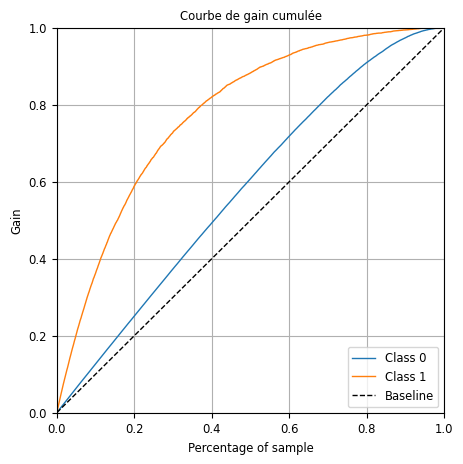

In [20]:
# affichage de la courbe de gain cumulée
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulée", fontsize="small");

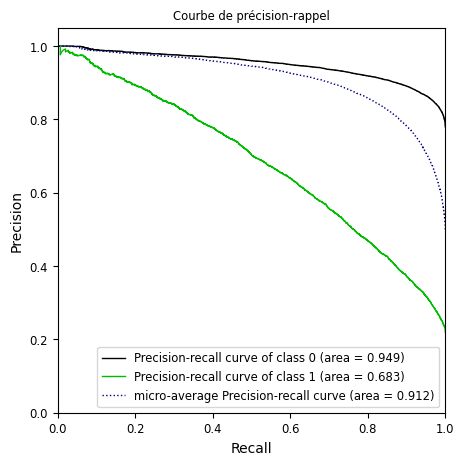

In [21]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

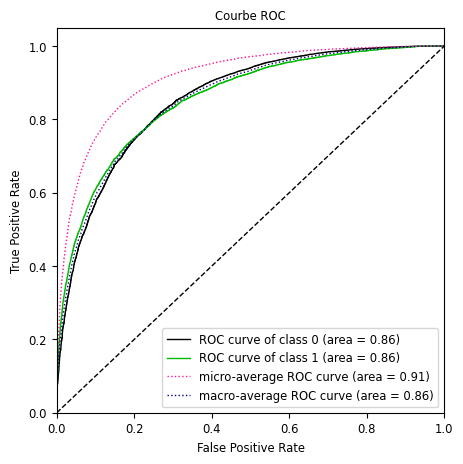

In [22]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [23]:
# sauvegarde des performances dans un fichier de sortie
pd.DataFrame([cv_scores_train.mean(), cv_scores_test.mean(),
              f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
             columns=['lr_' + param_ru]).to_csv('../scores/lr_'+scoring+'_'+param_ru+'.csv')

### Forêts Aléatoires

In [24]:
# définition du modèle
clf_rf  = RandomForestClassifier(class_weight={0:2, 1:1})

param_grid_rf  = [{'n_estimators' : [50, 100, 150],
                   'min_samples_leaf' : np.arange(1,6,1),
                   'max_features' : ['sqrt', 'log2']}]

gcv_rf = GridSearchCV(clf_rf, param_grid_rf, scoring=scoring)

In [25]:
start_time = time.time()

# entraînement du modèle
gcv_rf.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_rf.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 150} 

Accuracy Score: 0.855671567582925 

Train Data Score: 1.0
Test Data Score: 0.855671567582925

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20877  1085
1             2979  3217

               precision    recall  f1-score   support

           0       0.88      0.95      0.91     21962
           1       0.75      0.52      0.61      6196

    accuracy                           0.86     28158
   macro avg       0.81      0.73      0.76     28158
weighted avg       0.85      0.86      0.85     28158

Running Time: 0:24:31.747503


- la méthode de forêt aléatoire **fait l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.52.
- la spécificité (taux de vrais négatifs) vaut 0.95.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est très bon (0.91).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.61).

La classe '1' est caractérisée par une précision correcte, ce qui signifie que la classe est plutôt bien détectée, et un rappel très faible, ce qui signifie que la classe inclut beaucoup d'observations d'autres classes lorsqu'elle est détectée.

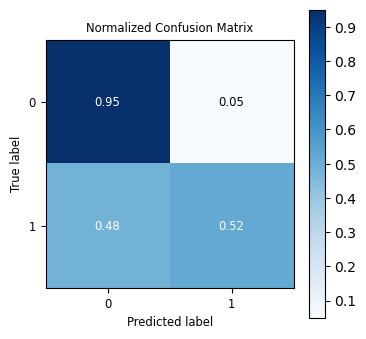

In [26]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), 
                                    title_fontsize='small', text_fontsize='small');

In [27]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_rf.cv_results_).loc[:,['params','rank_test_score','mean_test_score',
                                                         'mean_fit_time','mean_score_time']]
grid.set_index('rank_test_score').sort_values(by='rank_test_score')

,params,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,
1,"{'max_features': 'log2', 'min_samples_leaf': 1...",0.851335,15.173398,0.670444
2,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.851219,9.965654,0.438260
3,"{'max_features': 'log2', 'min_samples_leaf': 1...",0.851006,10.250044,0.451855
4,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.850998,15.018328,0.668585
5,"{'max_features': 'log2', 'min_samples_leaf': 2...",0.850696,14.410071,0.643304
6,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.850607,13.907046,0.627547
7,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.850048,9.642368,0.426635
8,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.849897,5.023313,0.225992
9,"{'max_features': 'log2', 'min_samples_leaf': 2...",0.849826,9.521380,0.414144


In [28]:
# méthode d'évaluation du score sur le jeu d'entraînement par cross-validation
cv_scores_train = cross_val_score(gcv_rf, X_train_scaled, y_train, cv=3, scoring=scoring)

print('Cross-validation scores (train): {}'.format(cv_scores_train))
print('Average cross-validation score (train): {}'.format(cv_scores_train.mean()))

Cross-validation scores (train): [0.84993208 0.84899981 0.85256905]
Average cross-validation score (train): 0.8505003151941329


- **Le score de la méthode des forêts aléatoires pour le jeu d'entraînement est en moyenne de : 0.85**.

In [29]:
# méthode d'évaluation du score sur le jeu de test par cross-validation
cv_scores_test = cross_val_score(gcv_rf, X_test_scaled, y_test, cv=3, scoring=scoring)

print('Cross-validation scores (test): {}'.format(cv_scores_test))
print('Average cross-validation score (test): {}'.format(cv_scores_test.mean()))

Cross-validation scores (test): [0.84903047 0.85510335 0.85297251]
Average cross-validation score (test): 0.8523687761914909


- **Le score de la méthode des forêts aléatoires pour le jeu de test est en moyenne de : 0.85**.

In [30]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_rf.predict_proba(X_test_scaled)

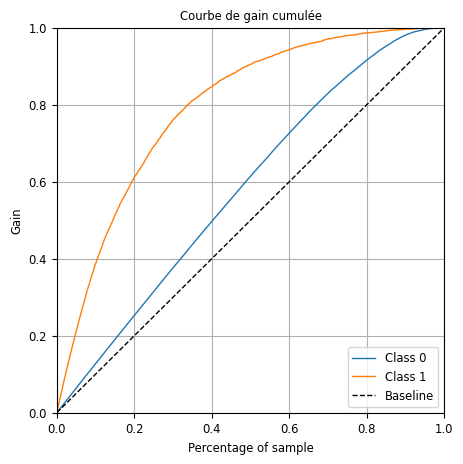

In [31]:
# affichage de la courbe de gain cumulée
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulée", fontsize="small");

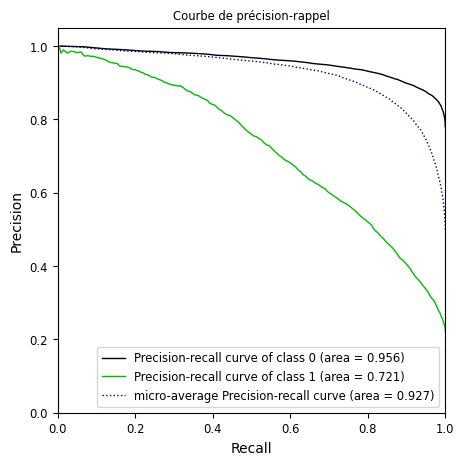

In [32]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

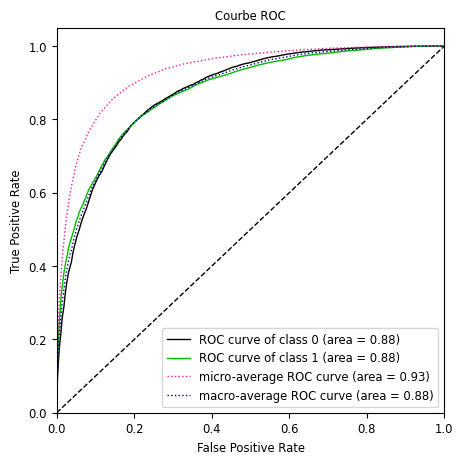

In [33]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [34]:
# sauvegarde des performances dans un fichier de sortie
pd.DataFrame([cv_scores_train.mean(), cv_scores_test.mean(), 
              f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
             columns=['rf_' + param_ru]).to_csv('../scores/rf_'+scoring+'_'+param_ru+'.csv')

### Séparateurs à Vaste Marge (SVM)

Les séparateurs à vaste marge (SVM) visent à résoudre les problèmes de classification en trouvant de bonnes frontières de décision entre deux ensembles de points appartenant à deux catégories différentes. Une frontière de décision peut être considérée comme une ligne ou une surface séparant les données d’apprentissage en deux demi-espaces correspondant à deux catégories de prédiction, soit dans le cadre de notre étude **"RainTomorrow=0"** et **"RainTomorrow=1"**. Pour classer de nouveaux points de données, il suffit de vérifier de quel côté de la frontière de décision ils se trouvent.

Les séparateurs à vaste marge procèdent à la recherche de ces frontières en deux étapes :
- Les données sont mises en correspondance avec une nouvelle représentation à haute dimension où la frontière de décision peut être exprimée sous la forme d’un hyperplan.
- Le séparateur à vaste marge identifie l'hyperplan qui maximise la distance au point le plus proche dans chaque classe. Cela permet à la frontière de bien s’adapter à de nouveaux échantillons en dehors de l’ensemble de données d’apprentissage.

La méthode de classification par SVM ne fournit pas directement de probabilités d'appartenir à chaque classe mais les classes prédites elle-mêmes en fonction du score qu'elle attribue à chaque individu. 

In [13]:
# définition du modèle: création d'un objet SVC (Support Vector Classificator)
clf_svm = SVC(probability=True, class_weight={0:2, 1:1})

# d'autres paramètres ont été considérés dans une étude préliminaire mais puisque les calculs étaient très long 
# à l'exécution, on ne garde ici que les paramètres qui ont donné les meilleurs résultats
param_grid_svm = {'kernel':['rbf'], 
                  'gamma':[0.5]}

gcv_svm = GridSearchCV(estimator=clf_svm, param_grid=param_grid_svm, scoring=scoring)

In [14]:
start_time = time.time()

# entraînement du modèle
grille = gcv_svm.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_svm.predict(X_test_scaled)

# # détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_svm.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'gamma': 0.5, 'kernel': 'rbf'} 

Accuracy Score: 0.8471482349598694 

Train Data Score: 0.864688490530858
Test Data Score: 0.8471482349598694

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            21534   428
1             3876  2320

               precision    recall  f1-score   support

           0       0.85      0.98      0.91     21962
           1       0.84      0.37      0.52      6196

    accuracy                           0.85     28158
   macro avg       0.85      0.68      0.71     28158
weighted avg       0.85      0.85      0.82     28158

Running Time: 14:20:22.892512


- la méthode SVM **fait l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (rappel de la classe positive) vaut 0.37.
- la spécificité (rappel de la classe négative) vaut 0.98.
- le F1-score concernant la classe 0 de la variable "RainTomorrow" est très bon (0.91).
- le F1-score concernant la classe 1 de la variable "RainTomorrow" est très faible (0.52).

La classe '1' est caractérisée par une précision élevée, ce qui signifie que la classe est bien détectée, et un rappel très faible, ce qui signifie que la classe inclut beaucoup d'observations d'autres classes lorsqu'elle est détectée.

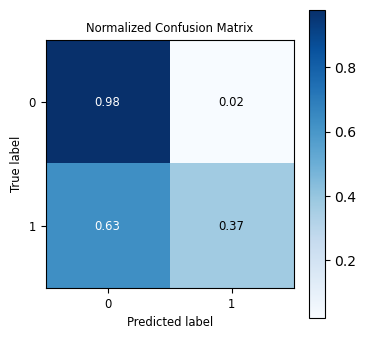

In [15]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), 
                                    title_fontsize='small', text_fontsize='small');

In [16]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_svm.cv_results_).loc[:,['params','rank_test_score','mean_test_score',
                                                         'mean_fit_time','mean_score_time']]
grid.set_index('rank_test_score').sort_values(by='rank_test_score')

,params,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,
1,"{'gamma': 0.5, 'kernel': 'rbf'}",0.841417,4862.37221,3286.614156


In [18]:
# cellule non exécutée car l'exécution du modèle prend beaucoup trop de temps

# méthode d'évaluation du score sur le jeu d'entraînement par cross-validation
# cv_scores_train = cross_val_score(gcv_svm, X_train_scaled, y_train, cv=3, scoring=scoring)

# print('Cross-validation scores (train): {}'.format(cv_scores_train))
# print('Average cross-validation score (train): {}'.format(cv_scores_train.mean()))

- **Le score de la méthode SVM pour le jeu d'entraînement est en moyenne de : XXXX**.

In [19]:
# cellule non exécutée car l'exécution du modèle prend beaucoup trop de temps

# méthode d'évaluation du score sur le jeu de test par cross-validation
# cv_scores_test = cross_val_score(gcv_svm, X_test_scaled, y_test, cv=3, scoring=scoring)

# print('Cross-validation scores (test): {}'.format(cv_scores_test))
# print('Average cross-validation score (test): {}'.format(cv_scores_test.mean()))

- **Le score de la méthode SVM pour le jeu de test est en moyenne de : XXXX**.

In [20]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_svm.predict_proba(X_test_scaled)

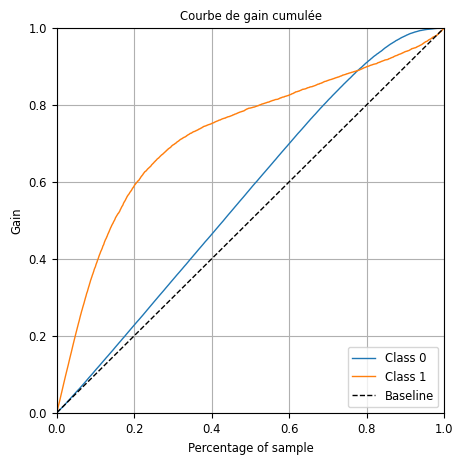

In [21]:
# affichage de la courbe de gain cumulée
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulée", fontsize="small");

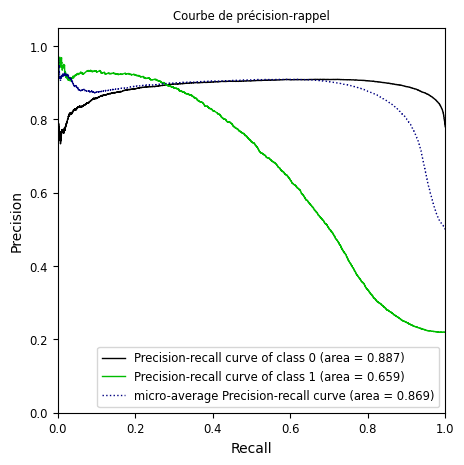

In [22]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

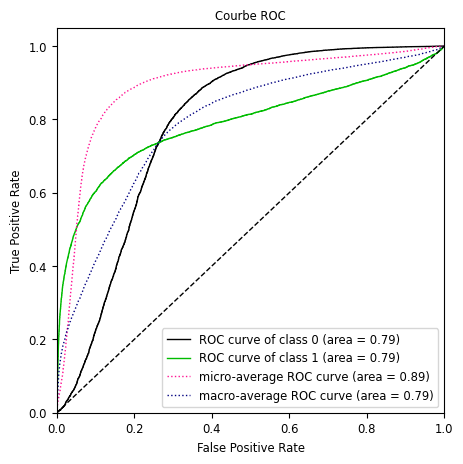

In [23]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [26]:
# cellule non exécutée car la cross validation n'a pas été effectuée

# sauvegarde des performances dans un fichier de sortie
# pd.DataFrame([cv_scores_train.mean(), cv_scores_test.mean(), 
#               f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
#              index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
#              columns=['svm_' + param_ru]).to_csv('../scores/svm_'+scoring+'_'+param_ru+'.csv')

In [ ]:
# sauvegarde des performances dans un fichier de sortie
pd.DataFrame([gcv_svm.score(X_train_scaled, y_train), gcv_svm.score(X_test_scaled, y_test), 
              f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
             columns=['svm_' + param_ru]).to_csv('../scores/svm_'+scoring+'_'+param_ru+'.csv')

### K-plus proches voisins

In [28]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

param_grid_knn = {'n_neighbors' : np.arange(20,41,1),
                  'metric' : ['minkowski','manhattan','chebyshev']}

gcv_knn = GridSearchCV(clf_knn, param_grid_knn, scoring=scoring)

In [29]:
start_time = time.time()

# entraînement du modèle
gcv_knn.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_knn.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_knn.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'metric': 'manhattan', 'n_neighbors': 29} 

Accuracy Score: 0.8528659705945024 

Train Data Score: 0.8556588445249448
Test Data Score: 0.8528659705945024

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20958  1004
1             3139  3057

               precision    recall  f1-score   support

           0       0.87      0.95      0.91     21962
           1       0.75      0.49      0.60      6196

    accuracy                           0.85     28158
   macro avg       0.81      0.72      0.75     28158
weighted avg       0.84      0.85      0.84     28158

Running Time: 1:09:13.431486


- la méthode des K-plus proches voisins **ne fait pas l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.49.
- la spécificité (taux de vrais négatifs) vaut 0.95.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est très bon (0.91).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.60).

La classe '1' est caractérisée par une précision correcte, ce qui signifie que la classe est plutôt bien détectée, et un rappel très faible, ce qui signifie que la classe inclut beaucoup d'observations d'autres classes lorsqu'elle est détectée.

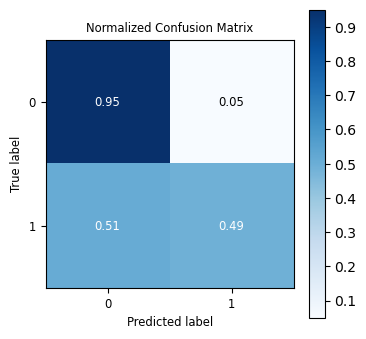

In [30]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), 
                                    title_fontsize='small', text_fontsize='small');

In [31]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_knn.cv_results_).loc[:,['params','rank_test_score','mean_test_score',
                                                         'mean_fit_time','mean_score_time']]
grid.set_index('rank_test_score').sort_values(by='rank_test_score')

,params,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,
1,"{'metric': 'manhattan', 'n_neighbors': 29}",0.848423,0.195941,15.243540
2,"{'metric': 'manhattan', 'n_neighbors': 31}",0.848369,0.203654,17.614849
3,"{'metric': 'manhattan', 'n_neighbors': 27}",0.848316,0.194251,14.820402
4,"{'metric': 'manhattan', 'n_neighbors': 39}",0.848290,0.196052,17.526884
5,"{'metric': 'manhattan', 'n_neighbors': 36}",0.848227,0.199793,16.640152
...,...,...,...,...
59,"{'metric': 'chebyshev', 'n_neighbors': 24}",0.844276,0.199068,9.384407
60,"{'metric': 'chebyshev', 'n_neighbors': 26}",0.844259,0.197854,9.128447
61,"{'metric': 'chebyshev', 'n_neighbors': 21}",0.844259,0.199996,8.777313


In [32]:
# méthode d'évaluation du score sur le jeu d'entraînement par cross-validation
cv_scores_train = cross_val_score(gcv_knn, X_train_scaled, y_train, cv=3, scoring=scoring)

print('Cross-validation scores (train): {}'.format(cv_scores_train))
print('Average cross-validation score (train): {}'.format(cv_scores_train.mean()))

Cross-validation scores (train): [0.84705538 0.84809419 0.84918627]
Average cross-validation score (train): 0.848111942750091


- **Le score de la méthode KNN pour le jeu d'entraînement est en moyenne de : 0.85**.

In [33]:
# méthode d'évaluation du score sur le jeu de test par cross-validation
cv_scores_test = cross_val_score(gcv_knn, X_test_scaled, y_test, cv=3, scoring=scoring)

print('Cross-validation scores (test): {}'.format(cv_scores_test))
print('Average cross-validation score (test): {}'.format(cv_scores_test.mean()))

Cross-validation scores (test): [0.8498828  0.85105476 0.8480716 ]
Average cross-validation score (test): 0.8496697208608567


- **Le score de la méthode KNN pour le jeu de test est en moyenne de : 0.85**.

In [34]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_knn.predict_proba(X_test_scaled)

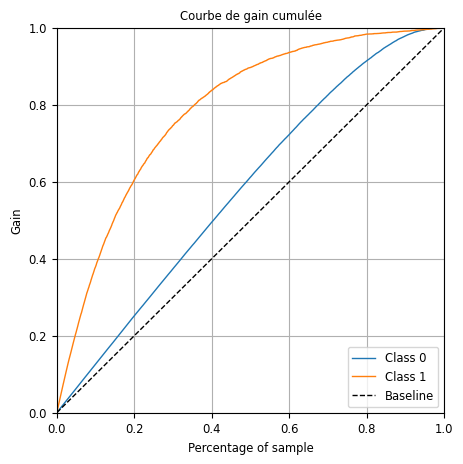

In [35]:
# affichage de la courbe de gain cumulée
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulée", fontsize="small");

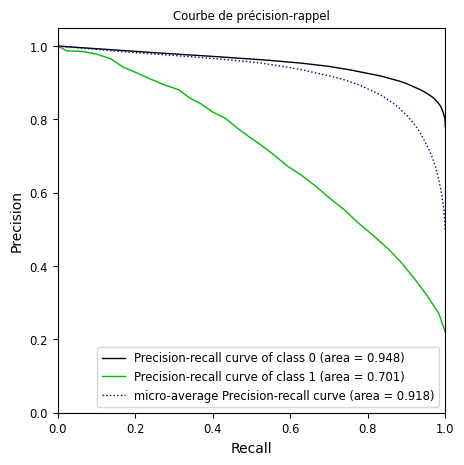

In [36]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

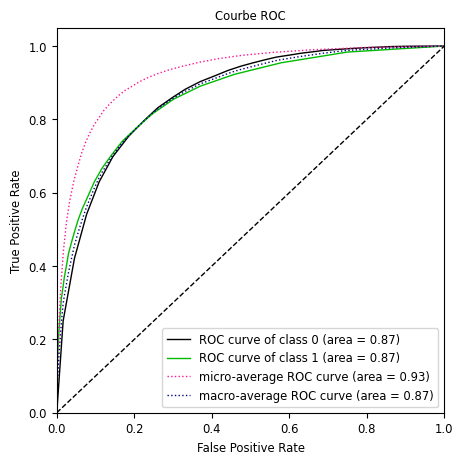

In [37]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [38]:
# scores de 3 modèles utilisant respectivement les matrices de Minkowski, Manhattan et Chebyshev 
# pour des valeurs de k allant de 1 à 40
score_minko = []
score_man = []
score_cheb = []

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_scaled, y_train)
  score_minko.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  knn.fit(X_train_scaled, y_train)
  score_man.append(knn.score(X_test_scaled, y_test))

for k in range(1,41):
  knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
  knn.fit(X_train_scaled, y_train)
  score_cheb.append(knn.score(X_test_scaled, y_test))

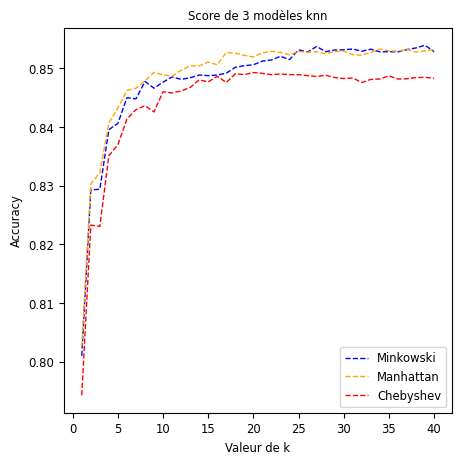

In [39]:
# affichage des scores des 3 modèles en fonction de k
plt.figure(figsize=(5,5))
plt.title("Score de 3 modèles knn", fontsize="small")
plt.plot(range(1,41), score_minko, color='blue', linestyle='dashed', lw=1, label='Minkowski')
plt.plot(range(1,41), score_man, color='orange', linestyle='dashed', lw=1, label='Manhattan')
plt.plot(range(1,41), score_cheb, color='red', linestyle='dashed', lw=1, label='Chebyshev')
plt.xlabel("Valeur de k", fontsize="small")
plt.xticks(fontsize="small")
plt.ylabel("Accuracy", fontsize="small")
plt.yticks(fontsize="small")
plt.legend(loc="lower right", fontsize="small");

In [40]:
# sauvegarde des performances dans un fichier de sortie
pd.DataFrame([cv_scores_train.mean(), cv_scores_test.mean(), 
              f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
             columns=['knn_' + param_ru]).to_csv('../scores/knn_'+scoring+'_'+param_ru+'.csv')

### Arbres de décision

In [41]:
# définition du modèle
clf_dt = DecisionTreeClassifier(class_weight={0:2, 1:1})

param_grid_dt = {'criterion' : ['entropy','gini'], 
                 'max_depth' : np.arange(2,6,1)}

gcv_dt = GridSearchCV(clf_dt, param_grid_dt, scoring=scoring)

In [42]:
start_time = time.time()

# entraînement du modèle
gcv_dt.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_dt.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'criterion': 'gini', 'max_depth': 5} 

Accuracy Score: 0.8325520278428866 

Train Data Score: 0.8303722842251996
Test Data Score: 0.8325520278428866

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            21591   371
1             4344  1852

               precision    recall  f1-score   support

           0       0.83      0.98      0.90     21962
           1       0.83      0.30      0.44      6196

    accuracy                           0.83     28158
   macro avg       0.83      0.64      0.67     28158
weighted avg       0.83      0.83      0.80     28158

Running Time: 0:00:05.260273


- la méthode des arbres de décision **ne fait pas l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.30.
- la spécificité (taux de vrais négatifs) vaut 0.98.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est très bon (0.90).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est faible (0.44).

La classe '1' est caractérisée par une précision élevée, ce qui signifie que la classe est plutôt bien détectée, et un rappel très faible, ce qui signifie que la classe inclut beaucoup d'observations d'autres classes lorsqu'elle est détectée.

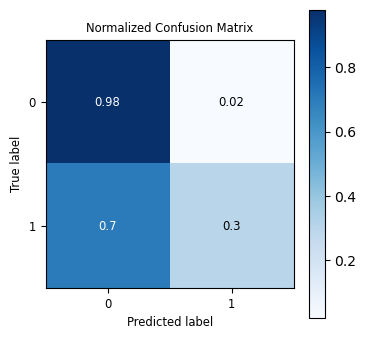

In [43]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), 
                                    title_fontsize='small', text_fontsize='small');

In [44]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_dt.cv_results_).loc[:,['params','rank_test_score','mean_test_score',
                                                         'mean_fit_time','mean_score_time']]
grid.set_index('rank_test_score').sort_values(by='rank_test_score')

,params,mean_test_score,mean_fit_time,mean_score_time
rank_test_score,,,,
1,"{'criterion': 'gini', 'max_depth': 5}",0.829316,0.161488,0.002944
2,"{'criterion': 'entropy', 'max_depth': 4}",0.827638,0.135829,0.002699
3,"{'criterion': 'entropy', 'max_depth': 5}",0.824574,0.164628,0.002841
4,"{'criterion': 'gini', 'max_depth': 3}",0.823580,0.107113,0.002393
5,"{'criterion': 'gini', 'max_depth': 4}",0.820828,0.137745,0.002572
6,"{'criterion': 'entropy', 'max_depth': 2}",0.820464,0.079048,0.002334
6,"{'criterion': 'entropy', 'max_depth': 3}",0.820464,0.107332,0.002817
8,"{'criterion': 'gini', 'max_depth': 2}",0.815811,0.077392,0.002599


In [45]:
# méthode d'évaluation du score sur le jeu d'entraînement par cross-validation
cv_scores_train = cross_val_score(gcv_dt, X_train_scaled, y_train, cv=3, scoring=scoring)

print('Cross-validation scores (train): {}'.format(cv_scores_train))
print('Average cross-validation score (train): {}'.format(cv_scores_train.mean()))

Cross-validation scores (train): [0.82697174 0.82803718 0.82918254]
Average cross-validation score (train): 0.8280638201528913


- **Le score de la méthode DT pour le jeu d'entraînement est en moyenne de : 0.76**.

In [46]:
# méthode d'évaluation du score sur le jeu de test par cross-validation
cv_scores_test = cross_val_score(gcv_dt, X_train_scaled, y_train, cv=3, scoring=scoring)

print('Cross-validation scores (test): {}'.format(cv_scores_test))
print('Average cross-validation score (test): {}'.format(cv_scores_test.mean()))

Cross-validation scores (test): [0.82697174 0.82803718 0.82918254]
Average cross-validation score (test): 0.8280638201528913


- **Le score de la méthode DT pour le jeu de test est en moyenne de : 0.76**.

In [47]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_dt.predict_proba(X_test_scaled)

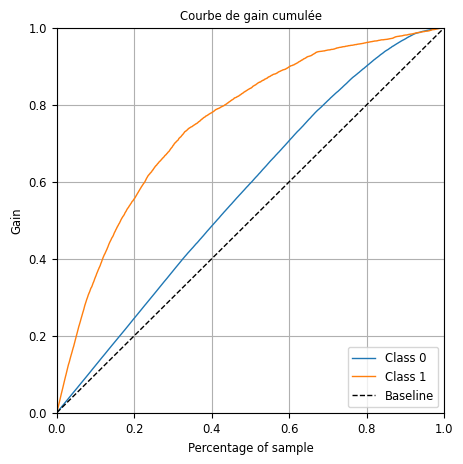

In [48]:
# affichage de la courbe de gain cumulée
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulée", fontsize="small");

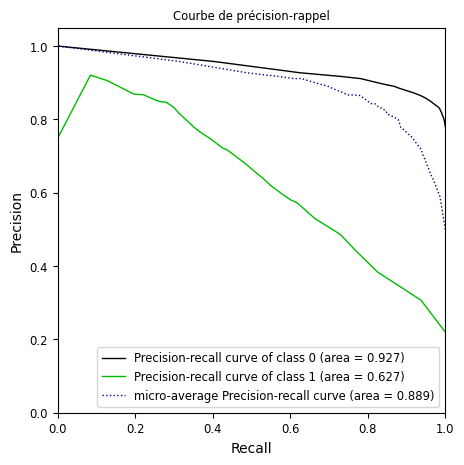

In [49]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

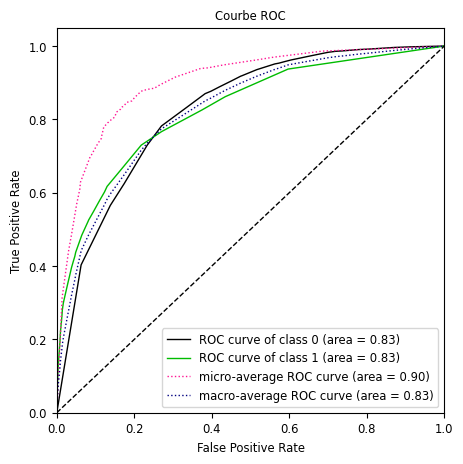

In [50]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [51]:
# importance des variables dans le jeu de données
clf_dt = gcv_dt.best_estimator_
clf_dt.fit(X_train_scaled,y_train)

feats = {}
for feature, importance in zip(df.columns, clf_dt.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.739298
WindGustSpeed,0.076680
Rainfall,0.073200
Sunshine,0.049416
Pressure9am,0.045803
clim_méditerranéen,0.008542
clim_chaud_humide,0.003752
Temp3pm,0.003309


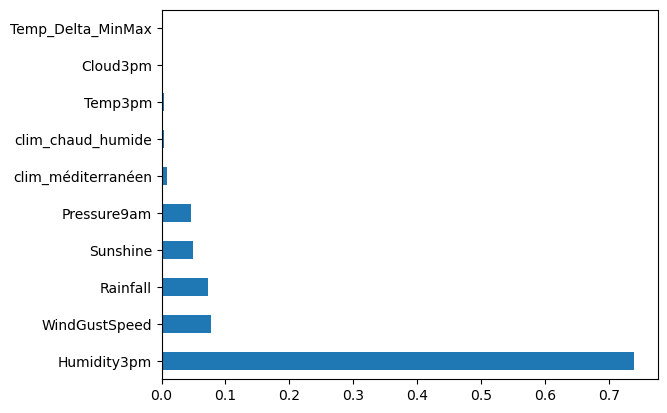

In [52]:
# affichage de l'importance des variables (MDI) dans le jeu de données
feature_imp = pd.Series(clf_dt.feature_importances_,index=data.columns)
feature_imp.nlargest(10).plot(kind='barh');

In [53]:
# sauvegarde des performances dans un fichier de sortie
pd.DataFrame([cv_scores_train.mean(), cv_scores_test.mean(), 
              f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)],
             index=['cv_scores_train','cv_scores_test','f1_class_1','recall_class_1','precision_class_1'], 
             columns=['dt_' + param_ru]).to_csv('../scores/dt_'+scoring+'_'+param_ru+'.csv')

## Résumé des performances

In [10]:
# concaténation des résultats de performance
if param_ru == 'none':
    if summary == 'accuracy' or summary == 'all':
        scores_dt_accuracy_no_resampling = pd.read_csv('../scores/dt_'+scoring+'_'+param_ru+'.csv', index_col=0)
        scores_knn_accuracy_no_resampling = pd.read_csv('../scores/knn_'+scoring+'_'+param_ru+'.csv', index_col=0)
        scores_svm_accuracy_no_resampling = pd.read_csv('../scores/svm_'+scoring+'_'+param_ru+'.csv', index_col=0)
        scores_rf_accuracy_no_resampling = pd.read_csv('../scores/rf_'+scoring+'_'+param_ru+'.csv', index_col=0)
        scores_lr_accuracy_no_resampling = pd.read_csv('../scores/lr_'+scoring+'_'+param_ru+'.csv', index_col=0)
    
        df_accuracy_no_resampling = pd.concat([scores_lr_accuracy_no_resampling, scores_rf_accuracy_no_resampling, 
                                               scores_svm_accuracy_no_resampling, scores_knn_accuracy_no_resampling,
                                               scores_dt_accuracy_no_resampling], axis=1)
    
    if summary == 'f1' or summary == 'all':
        scores_dt_f1_no_resampling = pd.read_csv('../scores/dt_'+scoring+'_'+param_ru+'.csv', index_col=0)
        scores_knn_f1_no_resampling = pd.read_csv('../scores/knn_'+scoring+'_'+param_ru+'.csv', index_col=0)
        scores_svm_f1_no_resampling = pd.read_csv('../scores/svm_'+scoring+'_'+param_ru+'.csv', index_col=0)
        scores_rf_f1_no_resampling = pd.read_csv('../scores/rf_'+scoring+'_'+param_ru+'.csv', index_col=0)
        scores_lr_f1_no_resampling = pd.read_csv('../scores/lr_'+scoring+'_'+param_ru+'.csv', index_col=0)
    
        df_f1_no_resampling = pd.concat([scores_lr_f1_no_resampling, scores_rf_f1_no_resampling, 
                                         scores_svm_f1_no_resampling, scores_knn_f1_no_resampling, 
                                         scores_dt_f1_no_resampling], axis=1)

In [11]:
# affichage du résumé des performances
if param_ru == 'none':
    if summary == 'accuracy' or summary == 'all':
        display(df_accuracy_no_resampling)
    if summary == 'f1' or summary == 'all':
        display(df_f1_no_resampling)

,lr_none,rf_none,svm_none,knn_none,dt_none
cv_scores_train,0.831420,0.850500,NaN,0.848112,0.828064
cv_scores_test,0.836707,0.852369,NaN,0.849670,0.828064
f1_class_1,0.467514,0.612879,0.518784,0.596081,0.439957
recall_class_1,0.326340,0.519206,0.374435,0.493383,0.298903
precision_class_1,0.823961,0.747792,0.844250,0.752770,0.833108
score_train,NaN,NaN,0.864688,NaN,NaN
score_test,NaN,NaN,0.847148,NaN,NaN
